# Synthesize a Table (CTGAN)

In this notebook, we'll use the SDV to create synthetic data for a single table and evaluate it. The SDV uses machine learning to learn patterns from real data and emulates them when creating synthetic data.

We'll use the **CTGAN** algorithm to do this. CTGAN uses generative adversarial networks (GANs) to create synthesize data with high fidelity.

_Last Edit: 5/21/2024

# 0. Installation

Install the SDV library.

In [1]:
%pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 49.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


**Important**: If you're using Google Colab, please restart the runtime by clicking `Runtime` in the top menu bar and then `Restart Session`

# 1. Loading the demo data
For this demo, we'll use a fake dataset that describes some fictional guests staying at a hotel.

In [25]:
import pandas as pd
import random
import numpy as np
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import get_column_pair_plot
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

In [17]:
# Read the CSV file from GitHub
real_data = pd.read_csv('https://raw.githubusercontent.com/MiamiCrypto/Capstone-Project-/main/skillsPred_df.csv')

# Create metadata object for the single table
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data)

# Visualize the metadata
metadata.visualize()


# Now you have the real_data and metadata variables
print(real_data.head())
print(metadata)

   Unnamed: 0  ID  Student_ID First_Name Last_Name  \
0           0   1   630427513      Sarah    Murphy   
1           1   2   446457407     Pamela   Sellers   
2           2   3   937243952     Joshua  Anderson   
3           3   4   250526321     Rachel    Mosley   
4           4   5   832949183    Colleen     Allen   

                          Email  \
0     Sarah.Murphy000@mymdc.net   
1   Pamela.Sellers000@mymdc.net   
2  Joshua.Anderson000@mymdc.net   
3    Rachel.Mosley000@mymdc.net   
4    Colleen.Allen000@mymdc.net   

                                               Major  \
0  Bachelor of Science in Applied Artificial Inte...   
1  Bachelor of Science in Applied Artificial Inte...   
2  Bachelor of Science in Applied Artificial Inte...   
3              Bachelor of Science in Data Analytics   
4              Bachelor of Science in Data Analytics   

                                              Skills  Salary  \
0  Big Data Technologies: Familiarity with Hadoop...       0   

**Details**: The data is available as a single table.
- `guest_email` is a _primary key_ that uniquely identifies every row
- Other columns have a variety of data types and some the data may be missing.

In [18]:
real_data.head()

,Unnamed: 0,ID,Student_ID,First_Name,Last_Name,Email,Major,Skills,Salary,Title,Industry,GPA,City,Graduated,Number_of_Skills
0,0,1,630427513,Sarah,Murphy,Sarah.Murphy000@mymdc.net,Bachelor of Science in Applied Artificial Inte...,Big Data Technologies: Familiarity with Hadoop...,0,Robotics Engineer,Technology and Software Development,3.72,Unincorporated Miami Dade,False,33
1,1,2,446457407,Pamela,Sellers,Pamela.Sellers000@mymdc.net,Bachelor of Science in Applied Artificial Inte...,Edge Computing: Familiarity with deploying AI ...,0,AI Data Scientist,Manufacturing and Supply Chain,3.00,Unincorporated Miami Dade,False,39
2,2,3,937243952,Joshua,Anderson,Joshua.Anderson000@mymdc.net,Bachelor of Science in Applied Artificial Inte...,Presentation Skills: Proficiency in presenting...,82693,AI Engineer,Retail and E-commerce,2.29,Bay Harbor Islands,True,33
3,3,4,250526321,Rachel,Mosley,Rachel.Mosley000@mymdc.net,Bachelor of Science in Data Analytics,Data Storytelling: Ability to create compellin...,87657,Operations Analyst,Manufacturing and Supply Chain,3.44,El Portal,True,40
4,4,5,832949183,Colleen,Allen,Colleen.Allen000@mymdc.net,Bachelor of Science in Data Analytics,"ETL Processes: Understanding of Extract, Trans...",70020,Marketing Analyst,Education and E-learning,2.56,Hialeah,True,39


The demo also includes **metadata**, a description of the dataset. It includes the primary keys as well as the data types for each column (called "sdtypes").

# 2. Basic Usage

## 2.1 Creating a Synthesizer

An SDV **synthesizer** is an object that you can use to create synthetic data. It learns patterns from the real data and replicates them to generate synthetic data.

In [19]:
from sdv.single_table import CTGANSynthesizer

synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(real_data)

/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:86: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


<font color="maroon"><i><b>This step takes a few minutes.</b> For larger datasets, this phase may take longer. A drawback of a GAN-based model like CTGAN is performance.</i></font>

When this code finishes running, the synthesizer is ready to use.

## 2.2 Generating Synthetic Data
Use the `sample` function and pass in any number of rows to synthesize.

In [20]:
synthetic_data = synthesizer.sample(num_rows=10000)
synthetic_data.head()

,Unnamed: 0,ID,Student_ID,First_Name,Last_Name,Email,Major,Skills,Salary,Title,Industry,GPA,City,Graduated,Number_of_Skills
0,415302551,sdv-pii-ste5k,sdv-pii-dr8sn,Tracy,Kim,ashley05@example.com,Bachelor of Science in Applied Artificial Inte...,sdv-pii-j9vb5,0,Data Analyst,Marketing and Advertising,3.98,South William,False,31
1,706041928,sdv-pii-e62sb,sdv-pii-hpp90,Harold,Watkins,raymondlewis@example.net,Bachelor of Science in Data Analytics,sdv-pii-lc5y0,96805,Operations Analyst,Education and E-learning,3.76,Edwardsmouth,False,33
2,975629174,sdv-pii-k343l,sdv-pii-4hevm,Kimberly,Ortiz,merceromar@example.net,Bachelor of Science in Data Analytics,sdv-pii-bjg62,0,Machine Learning Engineer,Finance and Banking,3.09,East Clintonstad,False,35
3,526959801,sdv-pii-mtitn,sdv-pii-btvrt,Aaron,Harris,patricia36@example.org,Bachelor of Science in Applied Artificial Inte...,sdv-pii-jemtq,78281,Computer Vision Engineer,Energy and Utilities,2.20,South Natasha,False,35
4,684278013,sdv-pii-h40xw,sdv-pii-hhvq7,Kenneth,Mcintosh,blackwellbrian@example.org,Bachelor of Science in Data Analytics,sdv-pii-65dni,0,Business Intelligence Analyst,Telecommunications,2.89,South Stephanieton,True,34


The synthesizer is generating synthetic guests in the **same format as the original data**.

## 2.3 Evaluating Real vs. Synthetic Data

SDV has built-in functions for evaluating the synthetic data and getting more insight.

As a first step, we can run a **diagnostic** to ensure that the data is valid. SDV's diagnostic performs some basic checks such as:

- All primary keys must be unique
- Continuous values must adhere to the min/max of the real data
- Discrete columns (non-PII) must have the same categories as the real data
- Etc.

In [21]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 15/15 [00:00<00:00, 1454.94it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 312.17it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



<font color="green"><b>The score is 100%</b></font>, indicating that the data is fully valid.

We can also measure the **data quality** or the statistical similarity between the real and synthetic data. This value may vary anywhere from 0 to 100%.

In [22]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 211.57it/s]|
Column Shapes Score: 88.59%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:00<00:00, 257.55it/s]|
Column Pair Trends Score: 79.16%

Overall Score (Average): 83.88%



According to the score, the synthetic data is about 75% similar to the real data in terms of statistical similarity.

We can also get more details from the report. For example, the Column Shapes sub-score is 76%. Which columns had the highest vs. the lowest scores?

In [23]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,Major,TVComplement,0.991933
1,Salary,KSComplement,0.820833
2,Title,TVComplement,0.943833
3,Industry,TVComplement,0.977700
4,GPA,KSComplement,0.749867
5,Graduated,TVComplement,0.921567
6,Number_of_Skills,KSComplement,0.795700


## 2.4 Visualizing the Data
For more insights, we can visualize the real vs. synthetic data.

Let's perform a 1D visualization comparing a column of the real data to the synthetic data.

In [26]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='Title',
    metadata=metadata
)

fig.show()

We can also visualize in 2D, comparing the correlations of a pair of columns.

In [27]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_names=['Major', 'Industry'],
    metadata=metadata
)

fig.show()

## 2.5 Anonymization

In the original dataset, we had some sensitive columns such as the guest's email, billing address and phone number. In the synthetic data, these columns are **fully anonymized** -- they contain entirely fake values that follow the format of the original.

PII columns are not included in the quality report, but we can inspect them to see that they are different.

In [28]:
sensitive_column_names = ['Email', 'Salary', 'Student_ID']

real_data[sensitive_column_names].head(3)

,Email,Salary,Student_ID
0,Sarah.Murphy000@mymdc.net,0,630427513
1,Pamela.Sellers000@mymdc.net,0,446457407
2,Joshua.Anderson000@mymdc.net,82693,937243952


In [29]:
synthetic_data[sensitive_column_names].head(3)

,Email,Salary,Student_ID
0,ashley05@example.com,0,sdv-pii-dr8sn
1,raymondlewis@example.net,96805,sdv-pii-hpp90
2,merceromar@example.net,0,sdv-pii-4hevm


## 2.6 Saving and Loading
We can save the synthesizer to share with others and sample more synthetic data in the future.

In [30]:
synthesizer.save('my_synthesizer.pkl')

synthesizer = CTGANSynthesizer.load('my_synthesizer.pkl')

# 3. CTGAN Customization
When using this synthesizer, we can make a tradeoff between training time and data quality using the `epochs` parameter: Higher `epochs` means that the synthesizer will train for longer, and ideally improve the data quality.


In [31]:
custom_synthesizer = CTGANSynthesizer(
    metadata,
    epochs=1000)
custom_synthesizer.fit(real_data)

<font color="maroon"><i><b>This code takes about 10 min to run.</b></i></font>

After we've trained our synthesizer, we can verify the changes to the data quality by creating some synthetic data and evaluating it.

In [32]:
synthetic_data_customized = custom_synthesizer.sample(num_rows=500)

quality_report = evaluate_quality(
    real_data,
    synthetic_data_customized,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 1568.43it/s]|
Column Shapes Score: 84.29%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:00<00:00, 308.29it/s]|
Column Pair Trends Score: 78.64%

Overall Score (Average): 81.46%



While GANs are able to model complex patterns and shapes, it is not easy to understand how they are learning -- but it is possible to modify the underlying architecture of the neural networks.

For users who are familiar with the GAN architecture, there are extra parameters you can use to tune CTGAN to your particular needs. For more details, see [the CTGAN documentation](https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/ctgansynthesizer).

Exporting the new Synthetic data data frame to CSV

In [34]:
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        10000 non-null  int64  
 1   ID                10000 non-null  object 
 2   Student_ID        10000 non-null  object 
 3   First_Name        10000 non-null  object 
 4   Last_Name         10000 non-null  object 
 5   Email             10000 non-null  object 
 6   Major             10000 non-null  object 
 7   Skills            10000 non-null  object 
 8   Salary            10000 non-null  int64  
 9   Title             10000 non-null  object 
 10  Industry          10000 non-null  object 
 11  GPA               10000 non-null  float64
 12  City              10000 non-null  object 
 13  Graduated         10000 non-null  bool   
 14  Number_of_Skills  10000 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(10)
memory usage: 1.1+ MB


In [35]:
# prompt: create csv file for synthetic_data

synthetic_data.to_csv('synthetic_data.csv', index=False)

In [33]:
# Original data frame
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        750 non-null    int64  
 1   ID                750 non-null    int64  
 2   Student_ID        750 non-null    int64  
 3   First_Name        750 non-null    object 
 4   Last_Name         750 non-null    object 
 5   Email             750 non-null    object 
 6   Major             750 non-null    object 
 7   Skills            750 non-null    object 
 8   Salary            750 non-null    int64  
 9   Title             750 non-null    object 
 10  Industry          750 non-null    object 
 11  GPA               750 non-null    float64
 12  City              750 non-null    object 
 13  Graduated         750 non-null    bool   
 14  Number_of_Skills  750 non-null    int64  
dtypes: bool(1), float64(1), int64(5), object(8)
memory usage: 82.9+ KB


# 4. What's Next?

For more information about the CTGAN Synthesizer, visit the **[documentation](https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/ctgansynthesizer)**.

**Need more help?** [Browse all tutorials](https://docs.sdv.dev/sdv/demos).

---

# About

The [Synthetic Data Vault Project](https://github.com/sdv-dev/SDV) was first created at MIT's Data to AI Lab in 2016. After 4 years of research and traction with enterprise, we created [DataCebo](https://datacebo.com/) in 2020 with the goal of growing the project. Today, DataCebo is the proud developer of SDV, the largest ecosystem for tabular synthetic data generation & evaluation.

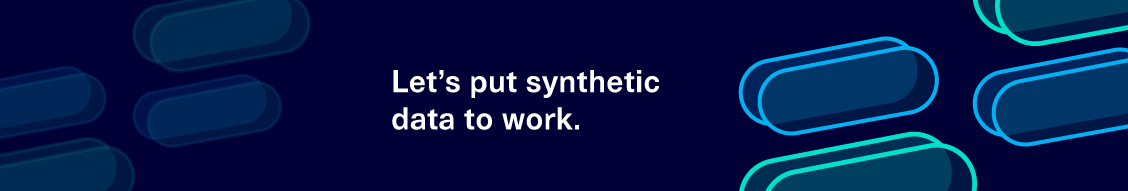